# MLP2 Data Preprocessing and Exploratory Data Analysis
## Authors: Mia Rodgers and Alex Larsen

In [1]:
# %pip install essentia

In [2]:

# import sys
# sys.path.append('/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages')
# from essentia import *


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt 
from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft
from os import listdir
from os.path import isfile, join
from pathlib import Path
import librosa
import seaborn as sns
from multiprocessing import Pool
# import essentia
%matplotlib inline

## GTZAN Dataset

used this link to get all filenames 
https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

In [4]:
genre_folder = '../rawdata/genres' 
genre_names = [f for f in listdir(path=genre_folder) if not isfile(join(genre_folder, f))] 

creating dict of genres and one random song in the file (for some reason `listdir(...)[0]` does not give the first file)

In [5]:
song_list = []
for g in genre_names:
    p = genre_folder + '/' + g # path for a genre folder
    for song in sorted(listdir(path=p)): # song at index 0 for each folder
        song_path = p+'/'+song
        time_series, sample_rate = librosa.load(Path(song_path))
        song_list.append([song_path, time_series, sample_rate, g])
        

In [6]:
song_df = pd.DataFrame(song_list, columns=['song_file', 'time_series', 'sample_rate', 'genre'])
song_df

,song_file,time_series,sample_rate,genre
0,../rawdata/genres/blues/blues.00000.wav,"[0.0073242188, 0.016601562, 0.0076293945, -0.0...",22050,blues
1,../rawdata/genres/blues/blues.00001.wav,"[0.0034179688, 0.0043029785, 0.001373291, 0.00...",22050,blues
2,../rawdata/genres/blues/blues.00002.wav,"[0.019012451, 0.047698975, 0.029418945, -0.018...",22050,blues
3,../rawdata/genres/blues/blues.00003.wav,"[-0.013000488, -0.03060913, -0.036071777, -0.0...",22050,blues
4,../rawdata/genres/blues/blues.00004.wav,"[-0.0063171387, -0.009277344, -0.008331299, -0...",22050,blues
...,...,...,...,...
995,../rawdata/genres/rock/rock.00095.wav,"[-0.0826416, -0.12426758, -0.09277344, -0.0747...",22050,rock
996,../rawdata/genres/rock/rock.00096.wav,"[0.07272339, 0.10369873, 0.10211182, 0.1071167...",22050,rock
997,../rawdata/genres/rock/rock.00097.wav,"[-0.03414917, -0.038360596, 0.0030822754, 0.02...",22050,rock
998,../rawdata/genres/rock/rock.00098.wav,"[0.0859375, 0.14483643, 0.14294434, 0.1555481,...",22050,rock


## Feature Extraction

Features to extract:
- BPM
- Zero-Crossing Rate (rate of sign changes from positive to negative)
- Spectral Centroid (weighted mean of frequencies present in the song)
- Spectral Rolloff (measures of shape of the signal, models human voice characteristics)
- Mel-Frequency Cepstral Coefficients (measures shape of spectral envelope)
- Chroma Frequencies (measure of frequencies of different pitches, separated into 12 bins)
- Intensity: loudness in dB (relative to max possible loudness)

In [7]:

song_df['bpm'] = song_df['time_series'].apply(lambda x: librosa.beat.tempo(y= x)[0])

In [8]:
# librosa.feature.zero_crossing_rate(y = song_df.iloc[0]['time_series'])[0]
song_df['zero_crossing_rate'] = song_df['time_series'].apply(lambda x: librosa.feature.zero_crossing_rate(y= x)[0])

# Extract the spectral centroid
song_df['spectral_centroid'] = song_df['time_series'].apply(lambda x: librosa.feature.spectral_centroid(y= x)[0])

# Extract the spectral rolloff
song_df['spectral_rolloff'] = song_df['time_series'].apply(lambda x: librosa.feature.spectral_rolloff(y= x)[0])

# Extract the mel-frequency cepstral coefficients
song_df['mfcc'] = song_df['time_series'].apply(lambda x: librosa.feature.mfcc(y= x)[0])

# Extract the chroma frequencies
song_df['chroma_frequencies'] = song_df['time_series'].apply(lambda x: librosa.feature.chroma_stft(y= x)[0])

song_df

,song_file,time_series,sample_rate,genre,bpm,zero_crossing_rate,spectral_centroid,spectral_rolloff,mfcc,chroma_frequencies
0,../rawdata/genres/blues/blues.00000.wav,"[0.0073242188, 0.016601562, 0.0076293945, -0.0...",22050,blues,123.046875,"[0.06494140625, 0.0830078125, 0.10791015625, 0...","[2122.977500863054, 2102.621073282696, 1955.28...","[4705.0048828125, 4640.4052734375, 4715.771484...","[-240.63542, -211.21436, -193.90889, -174.6187...","[0.33112547, 0.2349237, 0.8714165, 1.0, 0.7366..."
1,../rawdata/genres/blues/blues.00001.wav,"[0.0034179688, 0.0043029785, 0.001373291, 0.00...",22050,blues,107.666016,"[0.015625, 0.01806640625, 0.021484375, 0.01953...","[886.908553608008, 1051.8313429886564, 1125.26...","[1625.7568359375, 2260.986328125, 2723.9501953...","[-339.1464, -223.89967, -156.06529, -148.91068...","[0.36823648, 0.8158752, 1.0, 1.0, 1.0, 0.96526..."
2,../rawdata/genres/blues/blues.00002.wav,"[0.019012451, 0.047698975, 0.029418945, -0.018...",22050,blues,161.499023,"[0.04638671875, 0.06396484375, 0.0859375, 0.08...","[1510.2114102842334, 1419.0031858783832, 1386....","[2433.251953125, 2368.65234375, 2390.185546875...","[-92.80102, -77.73783, -96.38281, -108.587616,...","[0.27561098, 0.20460801, 0.19981515, 0.1902427..."
3,../rawdata/genres/blues/blues.00003.wav,"[-0.013000488, -0.03060913, -0.036071777, -0.0...",22050,blues,172.265625,"[0.01025390625, 0.0146484375, 0.0185546875, 0....","[694.2062878783131, 696.3364192016714, 659.964...","[1205.859375, 1248.92578125, 1119.7265625, 108...","[-220.65663, -201.52414, -213.41223, -220.4217...","[0.60287297, 0.36729065, 0.33834004, 0.3809551..."
4,../rawdata/genres/blues/blues.00004.wav,"[-0.0063171387, -0.009277344, -0.008331299, -0...",22050,blues,135.999178,"[0.03955078125, 0.06494140625, 0.08935546875, ...","[1367.5443360252789, 1552.9897966113344, 1630....","[2293.2861328125, 2788.5498046875, 3025.415039...","[-281.78323, -180.33914, -155.01845, -173.1693...","[0.19081402, 0.17394003, 0.06381712, 0.0384215..."
...,...,...,...,...,...,...,...,...,...,...
995,../rawdata/genres/rock/rock.00095.wav,"[-0.0826416, -0.12426758, -0.09277344, -0.0747...",22050,rock,103.359375,"[0.03369140625, 0.0556640625, 0.06787109375, 0...","[1734.4940509612445, 1751.4593436137102, 1908....","[3822.1435546875, 3822.1435546875, 3994.409179...","[-219.15886, -223.11674, -246.36456, -250.3081...","[0.29385182, 0.10223191, 0.080109894, 0.056004..."
996,../rawdata/genres/rock/rock.00096.wav,"[0.07272339, 0.10369873, 0.10211182, 0.1071167...",22050,rock,117.453835,"[0.056640625, 0.08642578125, 0.1064453125, 0.1...","[2297.078737668398, 2478.3145179375024, 2581.9...","[5221.8017578125, 5555.56640625, 5695.53222656...","[-170.0446, -160.2242, -171.14601, -169.37462,...","[0.36247975, 0.15929995, 0.15851365, 0.2090802..."
997,../rawdata/genres/rock/rock.00097.wav,"[-0.03414917, -0.038360596, 0.0030822754, 0.02...",22050,rock,129.199219,"[0.04443359375, 0.06298828125, 0.076171875, 0....","[1840.8348141085698, 1943.9263885931905, 1977....","[3380.712890625, 3531.4453125, 3919.04296875, ...","[-190.12563, -135.08618, -128.793, -151.30775,...","[0.57765675, 0.45933858, 0.40199614, 0.1929148..."
998,../rawdata/genres/rock/rock.00098.wav,"[0.0859375, 0.14483643, 0.14294434, 0.1555481,...",22050,rock,112.347147,"[0.0087890625, 0.01220703125, 0.0166015625, 0....","[975.5709555276273, 803.1524630516349, 735.644...","[1981.0546875, 1528.857421875, 1162.79296875, ...","[-211.01143, -214.89467, -239.67259, -246.5197...","[0.19745304, 0.16889966, 0.09611926, 0.0776163..."


In [9]:
corr_df = pd.DataFrame()
corr_df['genre'] = song_df['genre']
corr_df['bpm'] = song_df['bpm']
for col in song_df.columns.drop(['song_file', 'time_series', 'sample_rate', 'genre','bpm']):
    print(col)
    corr_df['avg_{0}'.format(col)] = song_df[col].apply(lambda x: x.mean())

corr_df.head()

zero_crossing_rate
spectral_centroid
spectral_rolloff
mfcc
chroma_frequencies


,genre,bpm,avg_zero_crossing_rate,avg_spectral_centroid,avg_spectral_rolloff,avg_mfcc,avg_chroma_frequencies
0,blues,123.046875,0.083045,1784.122641,3805.723030,-113.598824,0.362243
1,blues,107.666016,0.056040,1530.261767,3550.713616,-207.523834,0.460041
2,blues,161.499023,0.076291,1552.832481,3042.410115,-90.757164,0.272900
3,blues,172.265625,0.033309,1070.153418,2184.879029,-199.575134,0.341372
4,blues,135.999178,0.101461,1835.128513,3579.957471,-160.354172,0.192605


In [10]:
from scipy import stats


for c in corr_df.columns.drop('genre'):
    F, p = stats.f_oneway(corr_df[corr_df.genre == genre_names[0]][c],
                          corr_df[corr_df.genre == genre_names[1]][c],
                          corr_df[corr_df.genre == genre_names[2]][c],
                          corr_df[corr_df.genre == genre_names[3]][c],
                          corr_df[corr_df.genre == genre_names[4]][c],
                          corr_df[corr_df.genre == genre_names[5]][c],
                          corr_df[corr_df.genre == genre_names[6]][c],
                          corr_df[corr_df.genre == genre_names[7]][c],
                          corr_df[corr_df.genre == genre_names[8]][c],
                          corr_df[corr_df.genre == genre_names[9]][c])
    print(c,F)

bpm 9.509992300744322
avg_zero_crossing_rate 58.71637958076926
avg_spectral_centroid 97.49446582239021
avg_spectral_rolloff 110.888295771945
avg_mfcc 130.37855475639358
avg_chroma_frequencies 35.166805523797045


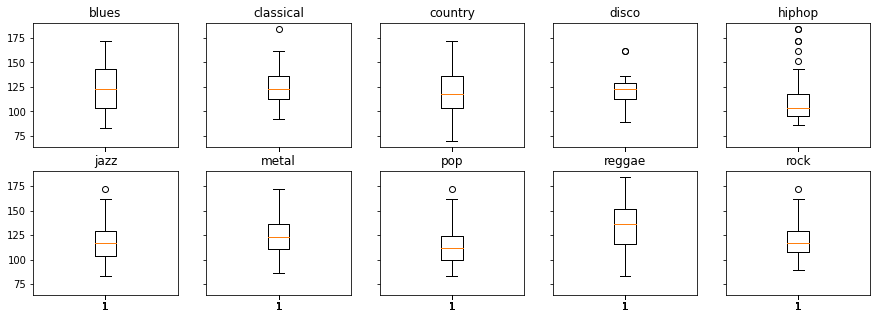

In [11]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=[15, 5])
count = 0

for g in genre_names:
    idx = (int(count/5), count % 5)
    df = song_df[song_df['genre'] == g]
    axs[idx].boxplot(df.bpm)
    axs[idx].set(title=g)
    count = count + 1

plt.show()


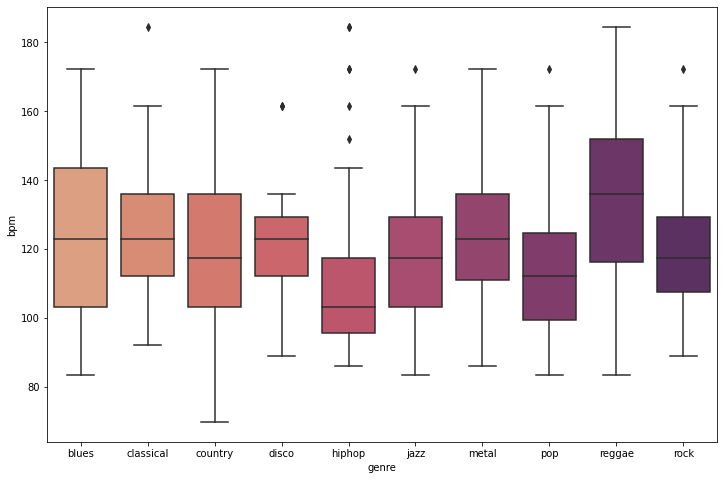

In [12]:
plt.figure(figsize=(12, 8))

sns.boxplot(y = song_df.bpm, x = song_df.genre, palette='flare')
plt.show()


plotting the sample song for each genre

In [13]:
jazz_songs = song_df[song_df['genre'] == 'jazz']['time_series']

In [14]:
# import librosa.display
# fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=[20, 8])
# count = 0

# for g in genre_names:
#     idx = (int(count/5), count % 5)
#     p = genre_folder + '/' + g + '/' + sample[g]
#     # getting information from the file
#     time_series, sample_rate = librosa.load(p)
#     # getting a matrix which contains amplitude values according to frequency and time indexes
#     stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))
#     # converting the matrix to decibel matrix
#     spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
#     img = librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=axs[idx])
#     axs[idx].set(title=g)
#     count = count + 1

# fig.colorbar(img, ax=axs, format='%+2.0f dB')
# plt.show()


In [15]:
# Create a csv file containing the preprocessed data
song_df.to_csv('../input/audio_data.csv')

## CSV Dataset

### Data Preprocessing

In [16]:
# Load the data
df = pd.read_csv('../rawdata/music_genre.csv')
df.head(200) 


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,76290.0,Joe Goddard,She Burns,41.0,0.19800,0.689,480686.0,0.569,0.007250,D,0.1080,-10.285,Major,0.0421,119.99600000000001,4-Apr,0.283,Electronic
196,60528.0,Borgore,Salad Dressing,43.0,0.01570,0.833,211882.0,0.938,0.071800,C#,0.0663,-2.242,Major,0.0551,128.024,4-Apr,0.790,Electronic
197,58743.0,Yellow Claw,P*$$YRICH,44.0,0.01270,0.825,155435.0,0.791,0.002270,D,0.0722,-4.700,Major,0.0495,101.999,4-Apr,0.512,Electronic
198,67553.0,Flux Pavilion,Got 2 Know,44.0,0.01110,0.659,350098.0,0.757,0.696000,G,0.1280,-4.802,Minor,0.0300,139.94899999999998,4-Apr,0.475,Electronic


In [17]:
df.tail()


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.0,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.0,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.0,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.0,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop
50004,63470.0,Naughty By Nature,Hip Hop Hooray,67.0,0.10200,0.862,267267.0,0.642,0.0,F#,0.272,-13.652,Minor,0.1010,99.20100000000001,4-Apr,0.765,Hip-Hop


In [18]:
# Find null data
print(df.isnull().sum())

# Drop the 5 rows of null data
df.dropna(inplace=True)

instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64


In [19]:
# Find data with missing values
df.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [20]:
# Print tracks with an unknown duration and tempo
df[df['duration_ms'] < 0][['instance_id', 'artist_name', 'track_name', 'duration_ms', 'tempo']]


,instance_id,artist_name,track_name,duration_ms,tempo
0,32894.0,Röyksopp,Röyksopp's Night Out,-1.0,100.889
13,62039.0,DJ Shadow,Broken Levee Blues,-1.0,154.745
16,83926.0,San Holo,One Thing,-1.0,151.756
24,40033.0,The Prodigy,Diesel Power,-1.0,105.919
35,27048.0,Fabian Mazur,If U Wanted To,-1.0,?
...,...,...,...,...,...
49956,37037.0,empty_field,What You Like (feat. Ty Dolla $ign & Wiz Khalifa),-1.0,140.005
49969,61010.0,Bone Thugs-N-Harmony,No Surrender,-1.0,85.963
49979,29598.0,Young Dolph,Thinking Out Loud,-1.0,140.101
49981,90232.0,Mac Miller,Party On Fifth Ave.,-1.0,97.101


In [21]:
df[df['tempo'] == '?'][['instance_id', 'artist_name',
                        'track_name', 'duration_ms', 'tempo']]


,instance_id,artist_name,track_name,duration_ms,tempo
5,89064.0,Axel Boman,Hello,519468.0,?
32,25836.0,PEEKABOO,Arrival,274286.0,?
35,27048.0,Fabian Mazur,If U Wanted To,-1.0,?
36,55617.0,Wax Tailor,The Games You Play,253333.0,?
39,69685.0,Dahu,Vessel,429941.0,?
...,...,...,...,...,...
49918,63058.0,Big Sean,Bigger Than Me,292520.0,?
49964,53387.0,Millonario,Rayas de Patrón,215200.0,?
49967,76585.0,MadeinTYO,I Want (feat. 2 Chainz),233293.0,?
49976,79654.0,Big Sean,Sunday Morning Jetpack,225067.0,?


In [22]:
# Mark values as missing or NaN
df['duration_ms'] = df['duration_ms'].replace(-1, np.NaN)
df['duration_ms'] = pd.to_numeric(df['duration_ms'], errors='coerce')
df['tempo'] = df['tempo'].replace('?', np.NaN)
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')

# We expect an empty dataframe here, as the values have been nulled out
df[df['duration_ms'] < 0][['instance_id', 'artist_name', 'track_name', 'duration_ms', 'tempo']].count()

instance_id    0
artist_name    0
track_name     0
duration_ms    0
tempo          0
dtype: int64

In [23]:
df[df['tempo'] == '?'][['instance_id', 'artist_name',
                        'track_name', 'duration_ms', 'tempo']].count()


instance_id    0
artist_name    0
track_name     0
duration_ms    0
tempo          0
dtype: int64

We will experiment with 2 options here: dropping rows with missing values, and replacing rows with missing values with the mean.

In [24]:
# Drop rows with missing values
dropped = df.copy()

dropped.dropna(inplace=True)

In [25]:
# Fill missing values with mean columnn values
mean_filled = df.copy()

mean_filled = mean_filled.groupby('music_genre').transform(lambda x: x.fillna(x.mean()))

C:\Users\alexs\AppData\Local\Temp\ipykernel_2232\2722770035.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  mean_filled = mean_filled.groupby('music_genre').transform(lambda x: x.fillna(x.mean()))
C:\Users\alexs\AppData\Local\Temp\ipykernel_2232\2722770035.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  mean_filled = mean_filled.groupby('music_genre').transform(lambda x: x.fillna(x.mean()))
C:\Users\alexs\AppData\Local\Temp\ipykernel_2232\2722770035.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only colum

### Exploratory Data Analysis

In [26]:
# Get the five-number summary for each field
df.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,4.506100e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,45020.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.455035e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,119.952961,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.114333e+05,0.264559,0.325409,0.161637,6.162990,0.101373,30.641701,0.247119
min,20002.000000,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.904670e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,94.941500,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.273600e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,119.879000,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.756800e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,140.471250,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


In [27]:
# Get the five-number summary for each field of dropped
dropped.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,40560.000000,40560.000000,40560.000000,40560.000000,4.056000e+04,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000
mean,55874.826430,44.276677,0.305974,0.558418,2.454895e+05,0.600330,0.181603,0.193820,-9.126369,0.093738,119.874523,0.456921
std,20731.018576,15.545617,0.341108,0.178652,1.101214e+05,0.264501,0.325710,0.161501,6.154679,0.101502,30.653215,0.246942
min,20002.000000,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,37994.750000,34.000000,0.020000,0.442000,1.904800e+05,0.433000,0.000000,0.097000,-10.843000,0.036100,94.893000,0.259000
50%,55899.500000,45.000000,0.144000,0.569000,2.275330e+05,0.644000,0.000157,0.126000,-7.277000,0.048900,119.755500,0.449000
75%,73817.500000,56.000000,0.550000,0.687000,2.757600e+05,0.817000,0.152000,0.244000,-5.174000,0.098800,140.344000,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


In [28]:
# Get the five-number summary for each field of mean_filled
mean_filled.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.455189e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,119.960388,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.061562e+05,0.264559,0.325409,0.161637,6.162990,0.101373,29.150294,0.247119
min,20002.000000,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.948750e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,96.775750,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.307057e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,120.494000,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.714400e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,139.468250,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


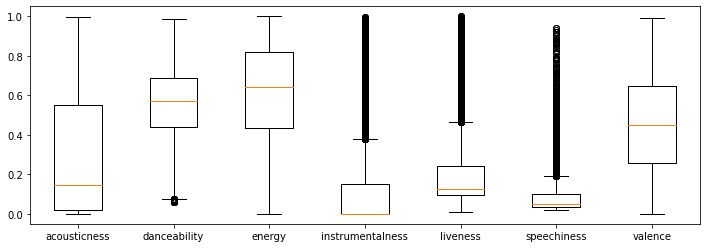

In [29]:
# Make a boxplot
cols = dropped[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

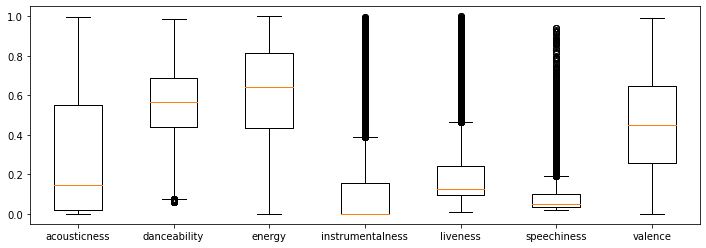

In [30]:
cols = mean_filled[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

In [31]:
# Normalize the data
scaler = MinMaxScaler()

dropped[['popularity', 'duration_ms', 'loudness', 'tempo']] = scaler.fit_transform(dropped[['popularity', 'duration_ms', 'loudness', 'tempo']])

dropped.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000
mean,55874.826430,0.447239,0.305974,0.558418,0.051306,0.600330,0.181603,0.193820,0.746596,0.093738,0.460001,0.456921
std,20731.018576,0.157026,0.341108,0.178652,0.024567,0.264501,0.325710,0.161501,0.121179,0.101502,0.164865,0.246942
min,20002.000000,0.000000,0.000000,0.059600,0.000000,0.000792,0.000000,0.009670,0.000000,0.022300,0.000000,0.000000
25%,37994.750000,0.343434,0.020000,0.442000,0.039034,0.433000,0.000000,0.097000,0.712798,0.036100,0.325640,0.259000
50%,55899.500000,0.454545,0.144000,0.569000,0.047301,0.644000,0.000157,0.126000,0.783008,0.048900,0.459361,0.449000
75%,73817.500000,0.565657,0.550000,0.687000,0.058060,0.817000,0.152000,0.244000,0.824414,0.098800,0.570094,0.648000
max,91759.000000,1.000000,0.996000,0.986000,1.000000,0.999000,0.996000,1.000000,1.000000,0.942000,1.000000,0.992000


In [32]:
# Normalize the data
mean_filled[['popularity', 'duration_ms', 'loudness', 'tempo']] = scaler.fit_transform(mean_filled[['popularity', 'duration_ms', 'loudness', 'tempo']])

mean_filled.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,0.446671,0.306383,0.558241,0.047768,0.599755,0.181601,0.193896,0.746451,0.093586,0.460463,0.456264
std,20725.256253,0.156990,0.341340,0.178632,0.022047,0.264559,0.325409,0.161637,0.121343,0.101373,0.156782,0.247119
min,20002.000000,0.000000,0.000000,0.059600,0.000000,0.000792,0.000000,0.009670,0.000000,0.022300,0.000000,0.000000
25%,37973.500000,0.343434,0.020000,0.442000,0.037251,0.433000,0.000000,0.096900,0.712463,0.036100,0.335767,0.257000
50%,55913.500000,0.454545,0.144000,0.568000,0.044692,0.643000,0.000158,0.126000,0.783018,0.048900,0.463333,0.448000
75%,73863.250000,0.565657,0.552000,0.687000,0.053152,0.815000,0.155000,0.244000,0.824434,0.098525,0.565384,0.648000
max,91759.000000,1.000000,0.996000,0.986000,1.000000,0.999000,0.996000,1.000000,1.000000,0.942000,1.000000,0.992000


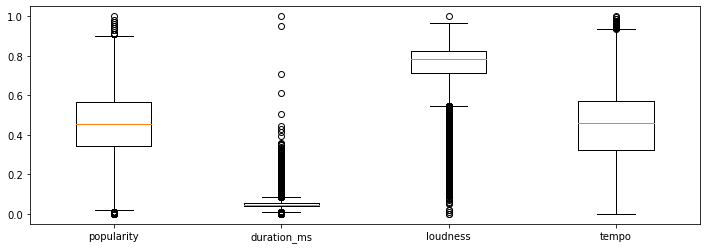

In [33]:
cols = dropped[['popularity', 'duration_ms', 'loudness', 'tempo']]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

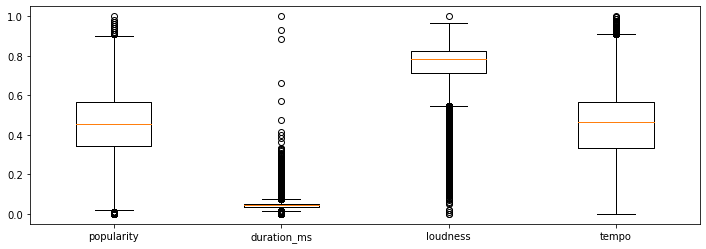

In [34]:
cols = mean_filled[['popularity', 'duration_ms', 'loudness', 'tempo']]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

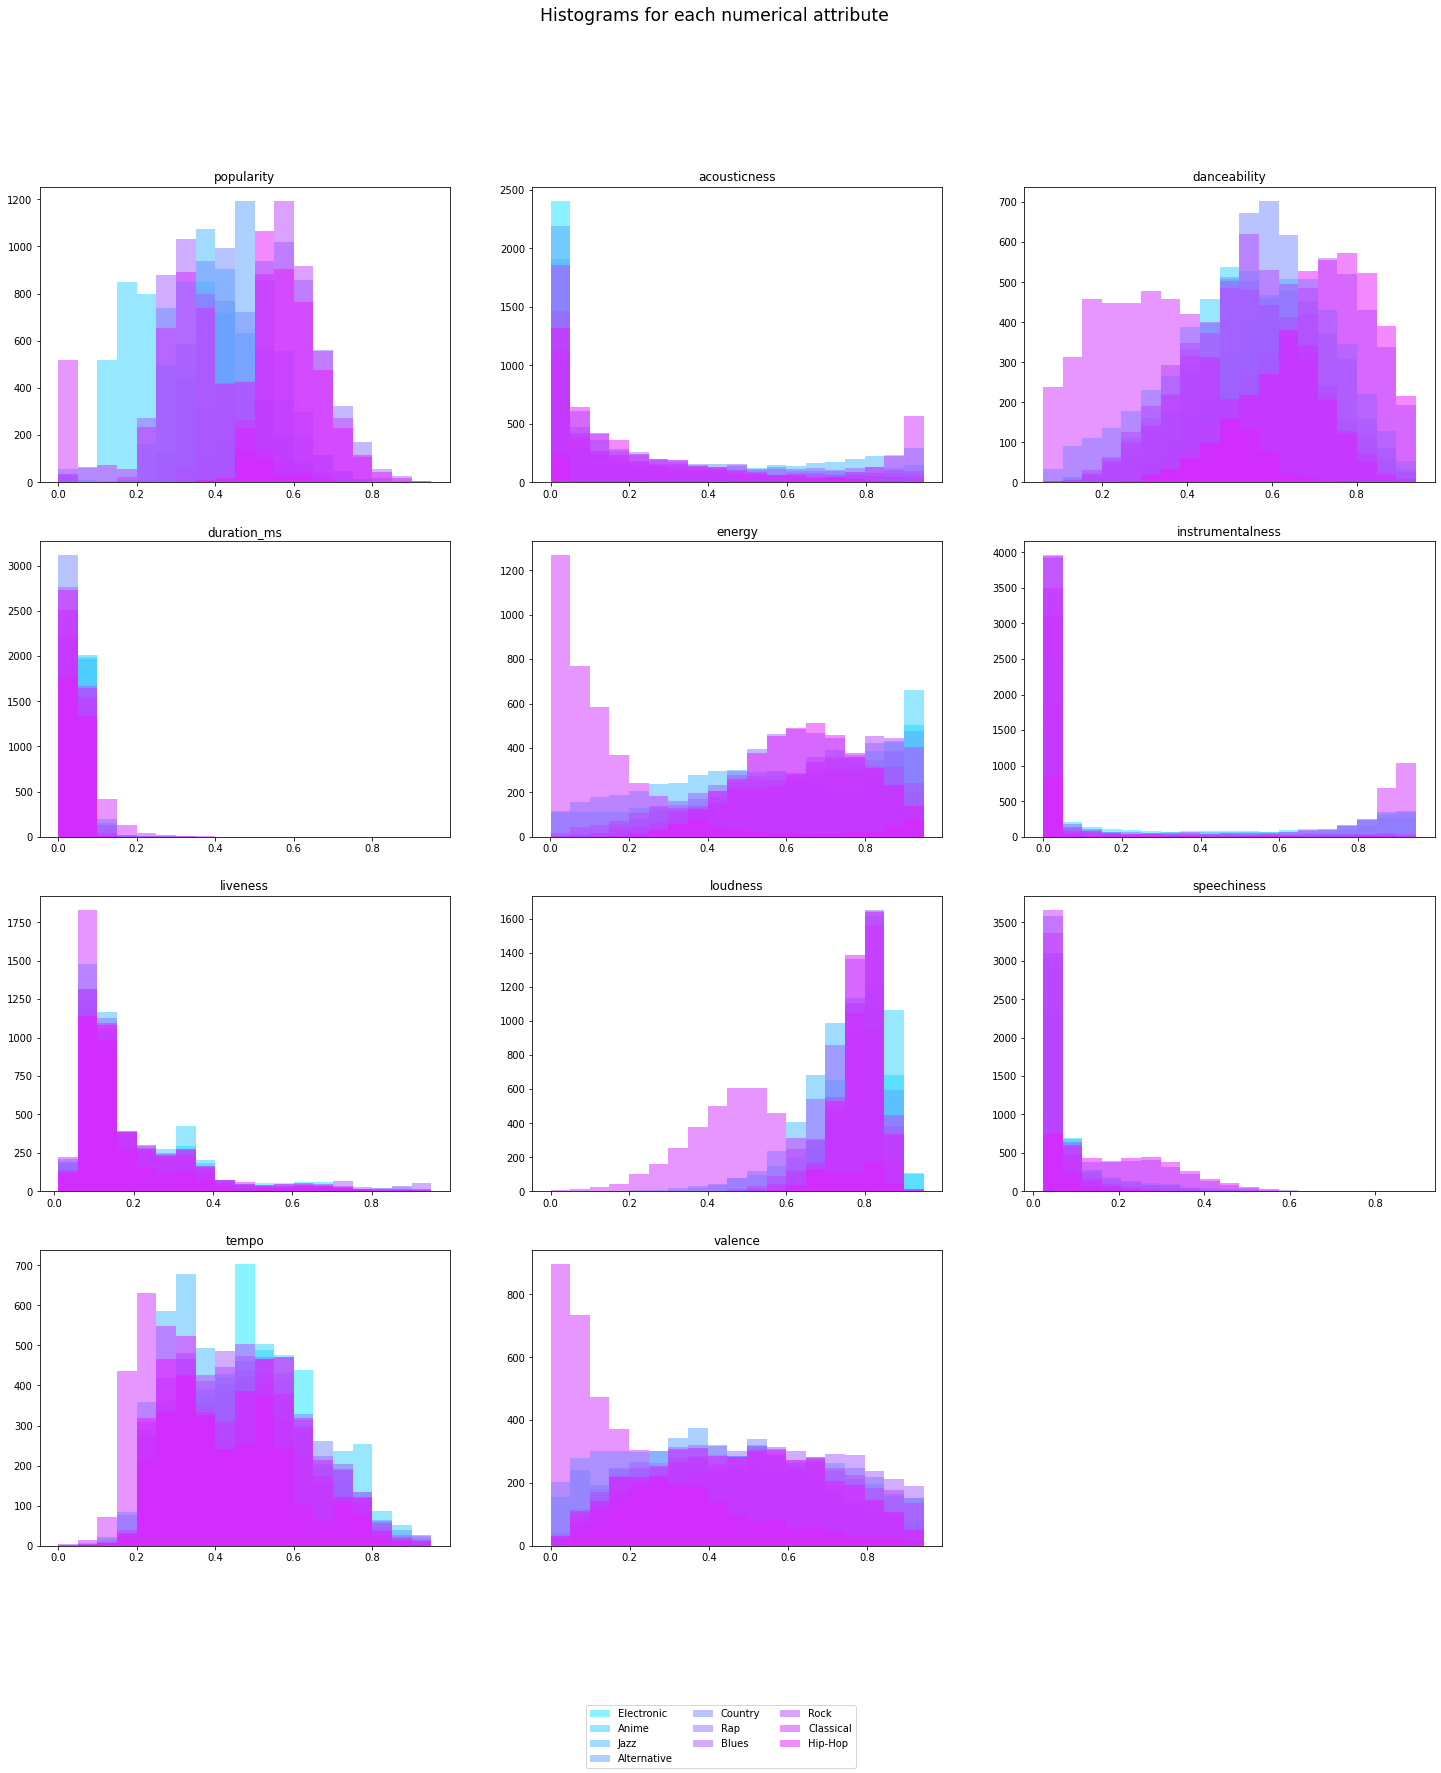

In [35]:
gs = dropped.music_genre.unique()
numeric = dropped.columns.drop(['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'obtained_date', 'music_genre'])
colors = sns.color_palette('cool',10)
nrows = 3
ncols = 4
fig, axs = plt.subplots(ncols,nrows, figsize = (25,25))
i = 0
for col in numeric:
    idx = (int(i/nrows), i%nrows)
    min = dropped[col].min()
    max = dropped[col].max()
    diff = max-min
    binw = [x*diff/20+min for x in range(20)]
    img = [axs[idx].hist(x=dropped[dropped['music_genre'] == gs[i]][col], bins=binw, alpha=0.5, histtype='bar', color = colors[i])
     for i in range(len(gs))]
    axs[idx].set(title = col)
    i += 1
fig.delaxes(axs[(int(i/nrows), i%nrows)])
fig.legend(labels=[dropped[dropped['music_genre'] == gs[i]]['music_genre'].iloc[0] for i in range(len(gs))], ncol=3, loc = 8, fontsize = 'medium', frameon=True, borderaxespad=0.5)
fig.suptitle('Histograms for each numerical attribute',size='xx-large')
plt.show()

In [36]:
# gs = dropped.music_genre.unique()
# numeric = dropped.columns.drop(
#     ['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'obtained_date', 'music_genre'])
# colors = sns.color_palette('cool', 10)
# nrows = 3
# ncols = 4
# fig, axs = plt.subplots(ncols, nrows, figsize=(25, 25))
# i = 0
# for col in numeric:
#     idx = (int(i / nrows), i % nrows)
#     min = dropped[col].min()
#     max = dropped[col].max()
#     diff = max - min
#     binw = [x * diff / 20 + min for x in range(20)]
#     img = [sns.boxplot(y=dropped[dropped['music_genre'] == gs[i]][col], x= gs[i])
#            for i in range(len(gs))]
#     axs[idx] = img
#     axs[idx].set(title=col)
#     i += 1
# fig.delaxes(axs[(int(i / nrows), i % nrows)])
# fig.legend(labels=[dropped[dropped['music_genre'] == gs[i]]['music_genre'].iloc[0] for i in range(
#     len(gs))], ncol=3, loc=8, fontsize='medium', frameon=True, borderaxespad=0.5)
# fig.suptitle('Histograms for each numerical attribute', size='xx-large')
# plt.show()


C:\Users\alexs\AppData\Local\Temp\ipykernel_2232\3375506821.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


[Text(0.5, 0, 'popularity'),
 Text(1.5, 0, 'acousticness'),
 Text(2.5, 0, 'danceability'),
 Text(3.5, 0, 'duration_ms'),
 Text(4.5, 0, 'energy'),
 Text(5.5, 0, 'instrumentalness'),
 Text(6.5, 0, 'liveness'),
 Text(7.5, 0, 'loudness'),
 Text(8.5, 0, 'speechiness'),
 Text(9.5, 0, 'tempo'),
 Text(10.5, 0, 'valence')]

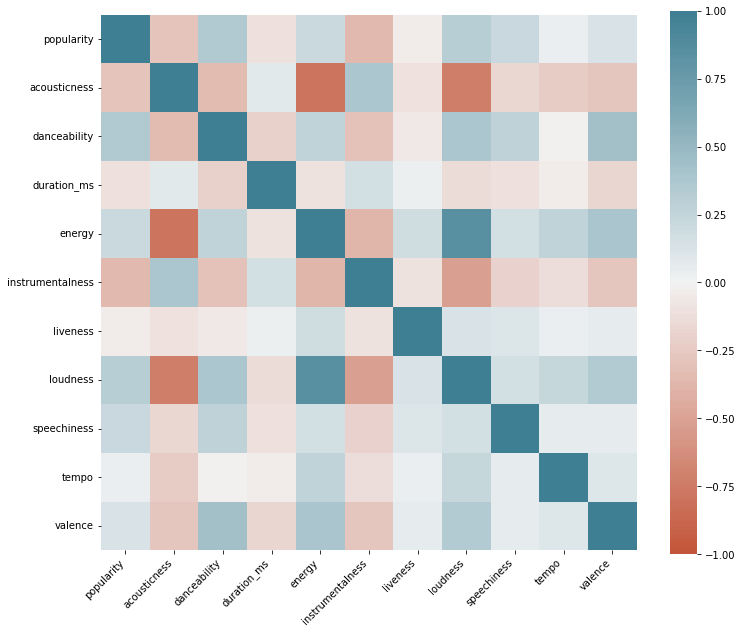

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(1)

# Compute the correlation matrix
corr = dropped.drop(columns=['instance_id']).corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12,10))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


In [38]:
from scipy import stats

cs = df.columns.drop(['instance_id', 'artist_name',
                      'track_name','key','mode','obtained_date','music_genre'])
for c in cs:
    F, p = stats.f_oneway(dropped[dropped.music_genre == gs[0]][c],
                          dropped[dropped.music_genre == gs[1]][c],
                          dropped[dropped.music_genre == gs[2]][c],
                          dropped[dropped.music_genre == gs[3]][c],
                          dropped[dropped.music_genre == gs[4]][c],
                          dropped[dropped.music_genre == gs[5]][c],
                          dropped[dropped.music_genre == gs[6]][c],
                          dropped[dropped.music_genre == gs[7]][c],
                          dropped[dropped.music_genre == gs[8]][c],
                          dropped[dropped.music_genre == gs[9]][c])
    print(c,F)
# The greater the F score value the higher the correlation will be.


popularity 7388.910774000588
acousticness 2888.6088401772586
danceability 2756.5654069084258
duration_ms 310.6960785680013
energy 2430.8342230958933
instrumentalness 2443.8024597525446
liveness 61.02393059611777
loudness 4555.559315438988
speechiness 1780.0020558634362
tempo 219.47072272122088
valence 815.9490530984743


In [39]:
# Create a csv file containing the preprocessed data
dropped.to_csv('../input/dropped.csv')
mean_filled.to_csv('../input/mean_filled.csv')